In [1]:
!nvidia-smi

Wed Jan 22 10:39:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 27%   27C    P8    12W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   25C    P8     4W / 250W |     10MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')

from ce_utils import load_data, one_hot, test_batch_idxs, batch_flatten
from ce_utils import model_prob
from ce_utils import classification_metric
from ce_model import binary_model, ensemble_model

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [5]:
import glob
import cv2


def load_data(phase, cls, les = None, data = 'sm', data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed', 
              extract_name = True, image_ch = 'bgr'):
    """
    phase = 'train', 'test'
    cls: [les]  
      'n': ['neg']
      'h': ['redspot', 'angio', 'active'], 
      'd': ['ero', 'ulc', 'str'],
      'p': ['amp', 'lym', 'tum']}
    """
    lesions = dict(neg = 'negative', 
                   redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                   ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                   amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
    classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

    path = os.path.join(data_dir, data, phase, classes[cls], lesions[les])
    pathlist = glob.glob(path + '/*.jpg')
    
    new_pathlist = []
    for p in pathlist:
        name = os.path.basename(p)
        name_seg1 = name.split('___')[0]
        if not ('f_' in name_seg1 or 'r1_' in name_seg1 or 'r2_' in name_seg1 or 'r3_' in name_seg1):
            new_pathlist.append(p)
    return load_image_from_path(new_pathlist, image_ch = image_ch, extract_name = extract_name)

def load_image_from_path(pathlist,image_ch = 'bgr', extract_name = False):
    data = []
    for i in pathlist:
        temp = cv2.imread(i)
        if image_ch == 'bgr':
            pass
        elif image_ch == 'rgb':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
        elif image_ch == 'hsv':
            temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
        data.append(temp)
    if extract_name != False:
        name = []
        for i in pathlist:
            name.append(os.path.basename(i))
        return np.asarray(data), np.asarray(name)
    else:
        return np.asarray(data) 

In [6]:
neg_img, neg_name = load_data('test', 'n', 'neg', data = 'sm_v2')
redspot_img, redspot_name = load_data('test', 'h', 'redspot', data = 'sm_v2')
angio_img, angio_name = load_data('test', 'h', 'angio', data = 'sm_v2')
active_img, active_name = load_data('test', 'h', 'active', data = 'sm_v2')
ero_img, ero_name = load_data('test', 'd', 'ero', data = 'sm_v2')
ulcer_img, ulcer_name = load_data('test', 'd', 'ulcer', data = 'sm_v2')
str_img, str_name = load_data('test', 'd', 'str', data = 'sm_v2')

In [7]:
neg_label = one_hot(neg_img, 0)
redspot_label = one_hot(redspot_img, 1)
angio_label = one_hot(angio_img, 1)
active_label = one_hot(active_img, 1)
ero_label = one_hot(ero_img, 1)
ulcer_label = one_hot(ulcer_img, 1)
str_label = one_hot(str_img, 1)

print("negative:",neg_img.shape, neg_label.shape)
print("red spot:",redspot_img.shape, redspot_label.shape)
print("angioectasia:",angio_img.shape, angio_label.shape)
print("active_bleeding:",active_img.shape, active_label.shape)
print("erosion:",ero_img.shape, ero_label.shape)
print("ulcer:",ulcer_img.shape, ulcer_label.shape)
print("stricture:",str_img.shape, str_label.shape)

negative: (1561, 512, 512, 3) (1561, 2)
red spot: (139, 512, 512, 3) (139, 2)
angioectasia: (5, 512, 512, 3) (5, 2)
active_bleeding: (108, 512, 512, 3) (108, 2)
erosion: (185, 512, 512, 3) (185, 2)
ulcer: (183, 512, 512, 3) (183, 2)
stricture: (26, 512, 512, 3) (26, 2)


# Model Inference

In [8]:
nh_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE2') if 'meta' in i and 'N1H9_' in i and 'core' not in i])
nd_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE2') if 'meta' in i and 'N1D9_' in i and 'core' not in i])
b_list = sorted([i[:-5] for i in os.listdir('./model/ENTIRE2') if 'meta' in i and 'B_' in i and 'core' not in i])

In [9]:
nh_list

['ENTIRE2_N1H9_2001101648_2940_val_acc_0.99_val_loss_0.031713',
 'ENTIRE2_N1H9_2001101656_3370_val_acc_0.99_val_loss_0.031599',
 'ENTIRE2_N1H9_2001101659_3550_val_acc_0.99_val_loss_0.025578',
 'ENTIRE2_N1H9_2001101705_3820_val_acc_1.00_val_loss_0.008359',
 'ENTIRE2_N1H9_2001101713_4250_val_acc_1.00_val_loss_0.006335']

In [10]:
nd_list

['ENTIRE2_N1D9_2001100152_4380_val_acc_0.98_val_loss_0.039794',
 'ENTIRE2_N1D9_2001100202_4900_val_acc_0.99_val_loss_0.039726',
 'ENTIRE2_N1D9_2001100204_4990_val_acc_0.99_val_loss_0.027827',
 'ENTIRE2_N1D9_2001100206_5120_val_acc_0.99_val_loss_0.026593',
 'ENTIRE2_N1D9_2001100219_5810_val_acc_0.99_val_loss_0.022532']

In [11]:
b_list

['ENTIRE2_B_2001060434_9410_val_acc_1.00_val_loss_0.019657',
 'ENTIRE2_B_2001060441_9870_val_acc_1.00_val_loss_0.011613',
 'ENTIRE2_B_2001060509_11910_val_acc_1.00_val_loss_0.009551',
 'ENTIRE2_B_2001060518_12540_val_acc_1.00_val_loss_0.008383',
 'ENTIRE2_B_2001060534_13690_val_acc_1.00_val_loss_0.006853',
 'ENTIRE2_B_2001081714_6900_val_acc_0.96_val_loss_0.094075',
 'ENTIRE2_B_2001081734_8800_val_acc_0.97_val_loss_0.077247',
 'ENTIRE2_B_2001081739_9300_val_acc_0.98_val_loss_0.059156',
 'ENTIRE2_B_2001081801_11400_val_acc_0.98_val_loss_0.050810',
 'ENTIRE2_B_2001081821_13300_val_acc_0.98_val_loss_0.042233',
 'ENTIRE2_B_2001100012_80_val_acc_0.60_val_loss_0.659025',
 'ENTIRE2_B_2001100013_150_val_acc_0.66_val_loss_0.650705',
 'ENTIRE2_B_2001100013_90_val_acc_0.57_val_loss_0.655705',
 'ENTIRE2_B_2001100014_160_val_acc_0.64_val_loss_0.616498',
 'ENTIRE2_B_2001100014_180_val_acc_0.68_val_loss_0.614124',
 'ENTIRE2_B_2001100015_10_val_acc_0.50_val_loss_0.691157',
 'ENTIRE2_B_2001100015_30_va

In [13]:
nh_path = './model/ENTIRE2/' + nh_list[-1]
nd_path = './model/ENTIRE2/' + nd_list[-1]
b_path = './model/ENTIRE2/' + b_list[-1]

NH_model = binary_model(nh_path)
ND_model = binary_model(nd_path)
E_model = ensemble_model(nh_path, nd_path)
B_model = binary_model(b_path)

W0122 10:41:27.540826 139715536172800 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


In [14]:
neg_e_output, neg_nh_output, neg_nd_output = model_prob(E_model, neg_img, model_type = 'ensemble')
redspot_e_output, redspot_nh_output, redspot_nd_output = model_prob(E_model, redspot_img, model_type = 'ensemble')
angio_e_output, angio_nh_output, angio_nd_output = model_prob(E_model, angio_img, model_type = 'ensemble')
active_e_output, active_nh_output, active_nd_output = model_prob(E_model, active_img, model_type = 'ensemble')
ero_e_output, ero_nh_output, ero_nd_output = model_prob(E_model, ero_img, model_type = 'ensemble')
ulcer_e_output, ulcer_nh_output, ulcer_nd_output = model_prob(E_model, ulcer_img, model_type = 'ensemble')
str_e_output, str_nh_output, str_nd_output  = model_prob(E_model, str_img, model_type = 'ensemble')

#: 1561 / Inference Time: 00:00:18
#: 139 / Inference Time: 00:00:02
#: 5 / Inference Time: 00:00:00
#: 108 / Inference Time: 00:00:01
#: 185 / Inference Time: 00:00:02
#: 183 / Inference Time: 00:00:02
#: 26 / Inference Time: 00:00:00


In [15]:
neg_b_output = model_prob(B_model, neg_img)
redspot_b_output = model_prob(B_model, redspot_img)
angio_b_output = model_prob(B_model, angio_img)
active_b_output = model_prob(B_model, active_img)
ero_b_output = model_prob(B_model, ero_img)
ulcer_b_output = model_prob(B_model, ulcer_img)
str_b_output  = model_prob(B_model, str_img)

#: 1561 / Inference Time: 00:00:07
#: 139 / Inference Time: 00:00:00
#: 5 / Inference Time: 00:00:00
#: 108 / Inference Time: 00:00:00
#: 185 / Inference Time: 00:00:00
#: 183 / Inference Time: 00:00:01
#: 26 / Inference Time: 00:00:00


# Evaluation

In [16]:
cls = classification_metric()

## Accuracy per lesion

In [17]:
neg_nh_acc = cls.accuracy(neg_label, neg_nh_output)
redspot_nh_acc = cls.accuracy(redspot_label, redspot_nh_output)
angio_nh_acc = cls.accuracy(angio_label, angio_nh_output)
active_nh_acc = cls.accuracy(active_label, active_nh_output)

Accuracy: 96.09 %
Accuracy: 91.37 %
Accuracy: 100.00 %
Accuracy: 97.22 %


In [18]:
neg_nd_acc = cls.accuracy(neg_label, neg_nd_output)
ero_nd_acc = cls.accuracy(ero_label, ero_nd_output)
ulcer_nd_acc = cls.accuracy(ulcer_label, ulcer_nd_output)
str_nd_acc = cls.accuracy(str_label, str_nd_output)

Accuracy: 91.93 %
Accuracy: 97.30 %
Accuracy: 97.81 %
Accuracy: 92.31 %


In [19]:
neg_b_acc = cls.accuracy(neg_label, neg_b_output)
redspot_b_acc = cls.accuracy(redspot_label, redspot_b_output)
angio_b_acc = cls.accuracy(angio_label, angio_b_output)
active_b_acc = cls.accuracy(active_label, active_b_output)
ero_b_acc = cls.accuracy(ero_label, ero_b_output)
ulcer_b_acc = cls.accuracy(ulcer_label, ulcer_b_output)
str_b_acc = cls.accuracy(str_label, str_b_output)

Accuracy: 97.89 %
Accuracy: 85.61 %
Accuracy: 100.00 %
Accuracy: 99.07 %
Accuracy: 95.14 %
Accuracy: 90.71 %
Accuracy: 88.46 %


In [20]:
neg_e_acc = cls.accuracy(neg_label, neg_e_output)
redspot_e_acc = cls.accuracy(redspot_label, redspot_e_output)
angio_e_acc = cls.accuracy(angio_label, angio_e_output)
active_e_acc = cls.accuracy(active_label, active_e_output)
ero_e_acc = cls.accuracy(ero_label, ero_e_output)
ulcer_e_acc = cls.accuracy(ulcer_label, ulcer_e_output)
str_e_acc = cls.accuracy(str_label, str_e_output)

Accuracy: 89.56 %
Accuracy: 92.81 %
Accuracy: 100.00 %
Accuracy: 99.07 %
Accuracy: 97.84 %
Accuracy: 98.91 %
Accuracy: 92.31 %


In [33]:
h_label = np.vstack([redspot_label, angio_label, active_label])
d_label = np.vstack([ero_label, ulcer_label, str_label])
labels = np.vstack([neg_label, h_label, d_label])

h_b_output = np.vstack([redspot_b_output, angio_b_output, active_b_output])
d_b_output = np.vstack([ero_b_output, ulcer_b_output, str_b_output])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])

h_e_output = np.vstack([redspot_e_output, angio_e_output, active_e_output])
d_e_output = np.vstack([ero_e_output, ulcer_e_output, str_e_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

## Confusion Matrix

In [21]:
nh_outputs = np.vstack([neg_nh_output, redspot_nh_output, angio_nh_output, active_nh_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label])

nh_CM = cls.con_mat(labels, nh_outputs)

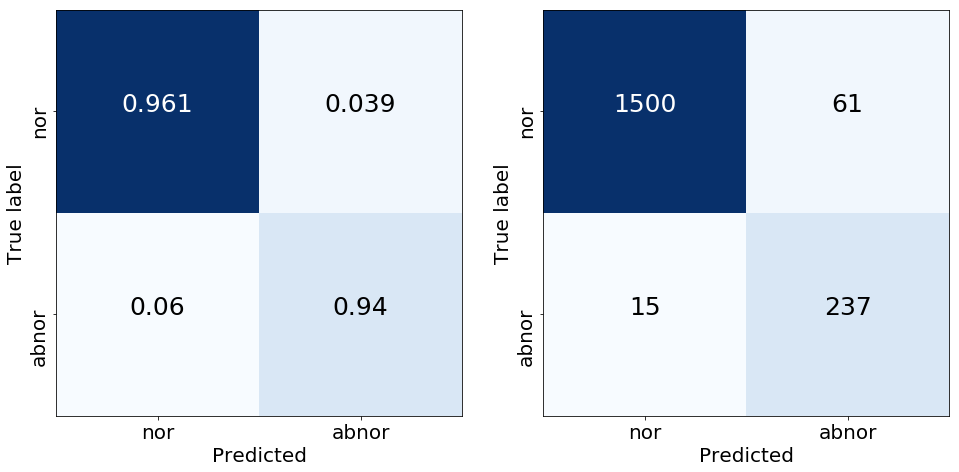

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nh_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [23]:
nd_outputs = np.vstack([neg_nd_output, ero_nd_output, ulcer_nd_output, str_nd_output])
labels = np.vstack([neg_label, ero_label, ulcer_label, str_label])

nd_CM = cls.con_mat(labels, nd_outputs)

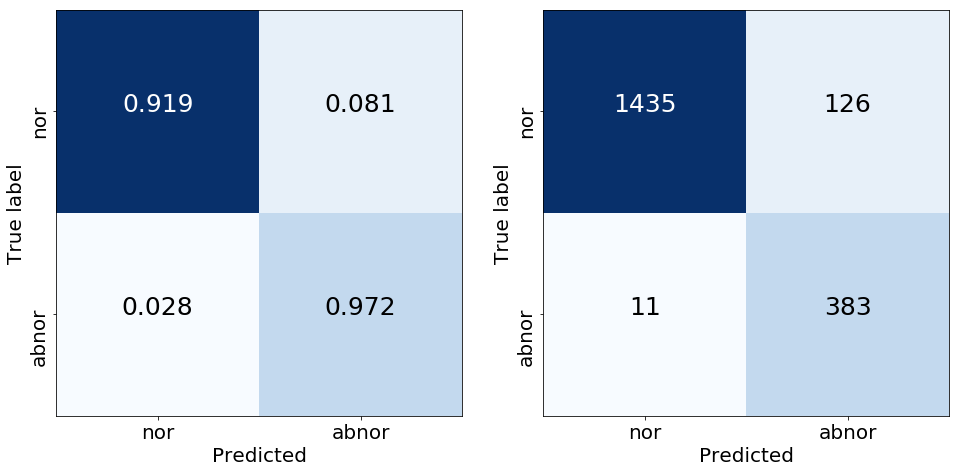

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(nd_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [25]:
e_outputs = np.vstack([neg_e_output, redspot_e_output, angio_e_output, active_e_output, ero_e_output, ulcer_e_output, str_e_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

e_CM = cls.con_mat(labels, e_outputs)

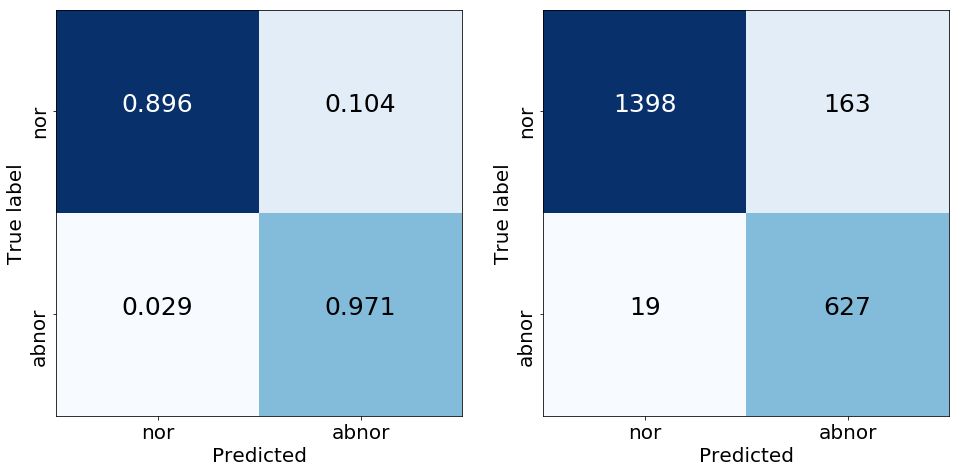

In [26]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(e_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(e_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

In [27]:
b_outputs = np.vstack([neg_b_output, redspot_b_output, angio_b_output, active_b_output, ero_b_output, ulcer_b_output, str_b_output])
labels = np.vstack([neg_label, redspot_label, angio_label, active_label, ero_label, ulcer_label, str_label])

b_CM = cls.con_mat(labels, b_outputs)

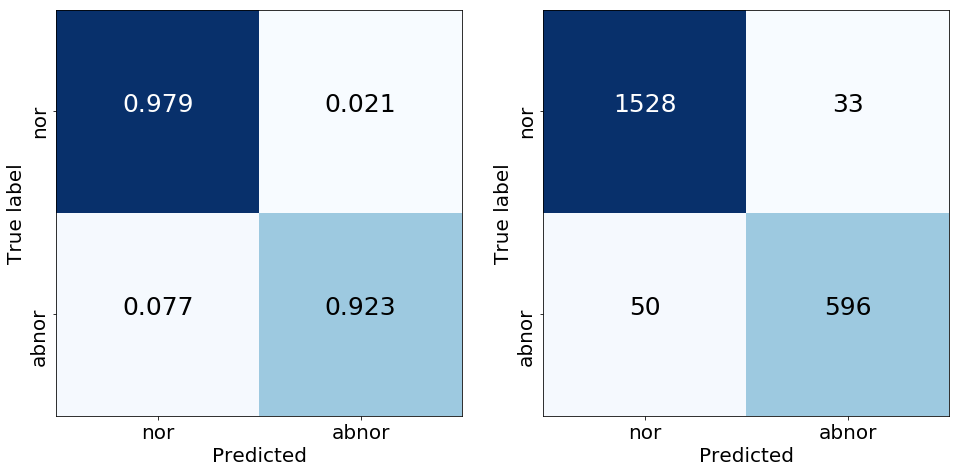

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
cls.plot_cm(b_CM, value_size = 25, label_size = 20)
plt.grid(False)
plt.subplot(122)
cls.plot_cm(b_CM, value_size = 25, label_size = 20, mode = 'num')
plt.grid(False)
plt.show()

## False cases

In [36]:
testset = np.vstack([neg_img, redspot_img, angio_img, active_img, 
                      ero_img, ulcer_img, str_img])

filename = np.hstack([neg_name, redspot_name, angio_name, active_name, 
                      ero_name, ulcer_name, str_name])

In [37]:
def fp_fn_list(name, prob, label):

    pred = np.argmax(prob, axis = 1)
    true = np.argmax(label, axis = 1)

    fp_list, fn_list = [], []
    for n, p, t in zip(name, pred, true):
        if p == 1:
            if p != t:
                fp_list.append(n)
        elif p == 0:
            if p != t:
                fn_list.append(n)
    return np.asarray(fp_list), np.asarray(fn_list)

In [38]:
b_fp_list, b_fn_list = fp_fn_list(name = filename, prob = b_outputs, label = labels)
e_fp_list, e_fn_list = fp_fn_list(name = filename, prob = e_outputs, label = labels)

In [39]:
b_fp_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in b_fp_list])]
b_fn_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in b_fn_list])]

e_fp_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in e_fp_list])]
e_fn_testset = testset[np.asarray([np.where(filename == i)[0][0] for i in e_fn_list])]

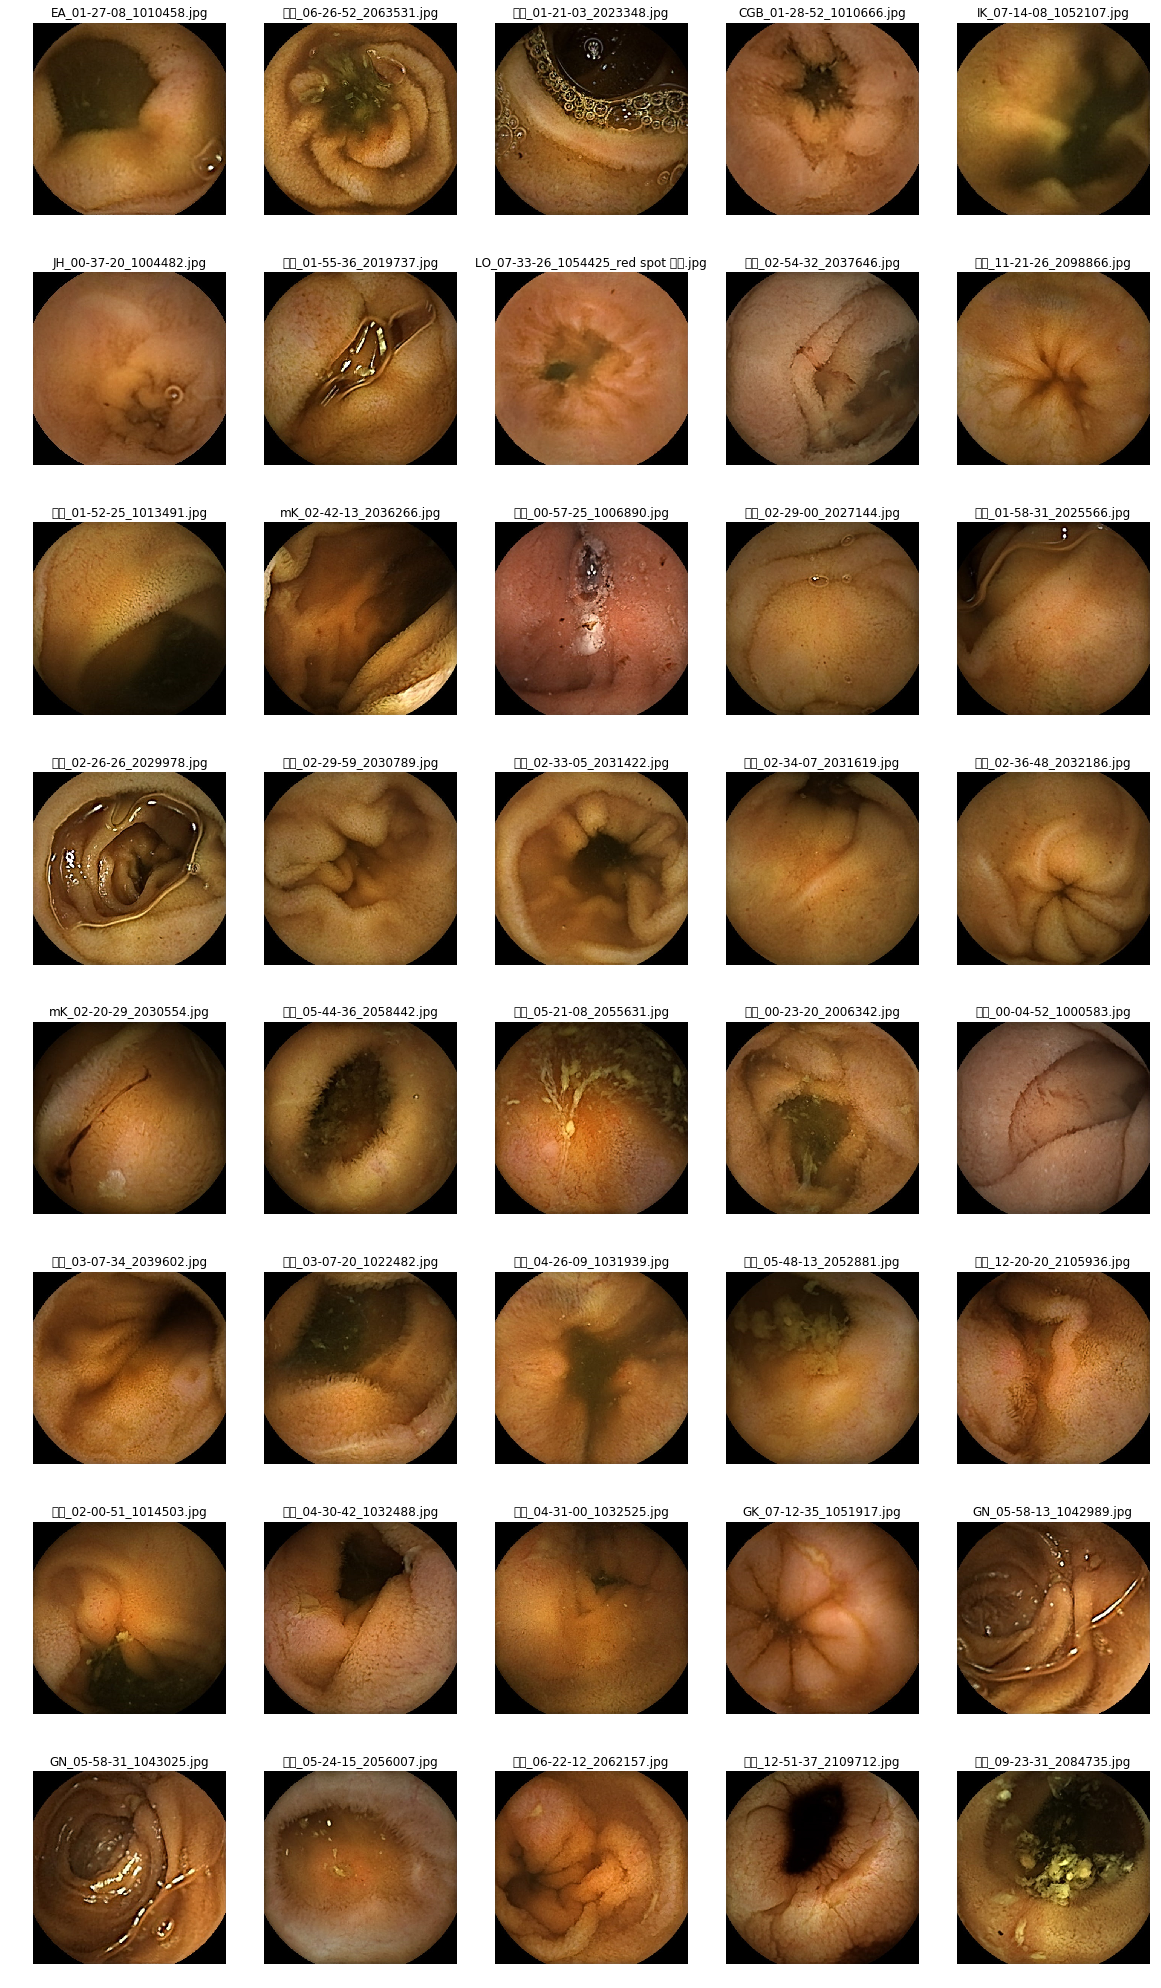

In [42]:
plt.figure(figsize = (20, 36))
for i, name, img in zip(range(len(b_fn_testset)), b_fn_list, b_fn_testset):
    if i+1 > 40:
        break
    plt.subplot(8, 5, i+1)
    plt.title(name.split('___')[0] + '_' + name.split('___')[1] + '_' + name.split('___')[2])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()

## ROC curve

In [30]:
from scipy.stats import sem, t
from scipy import mean

def conf_interval(data, conf_level = 0.95, mode = 'value', metric = 'Accr'):
    n = len(data)
    m = mean(data)
    std_err = sem(data)
    h = std_err * t.ppf((1 + conf_level) / 2, n - 1)

    start = m - h
    end = m + h
    
    if mode == 'value':
        return m, start, end
    elif mode == 'print':
        return print("{} --- {:.2f} ({:.2f} ~ {:.2f})".format(metric, m, start, end))

In [31]:
from sklearn.model_selection import KFold

def k_fold_idx(n_fold, dataset):
    kf = KFold(n_splits = n_fold, shuffle = True)
    train_idxs = []
    test_idxs = []
    for train_idx, test_idx in kf.split(dataset):
        train_idxs.append(train_idx)
        test_idxs.append(test_idx)
    return train_idxs, test_idxs

In [43]:
n_g = 10

_, neg_idxs = k_fold_idx(n_fold = n_g, dataset = neg_label)
_, h_idxs = k_fold_idx(n_fold = n_g, dataset = h_label)
_, d_idxs = k_fold_idx(n_fold = n_g, dataset = d_label)

In [44]:
def tri_shuffle(x, y, z):
    rand_idx = np.random.choice(len(x), len(x), replace = False)
    return x[rand_idx], y[rand_idx], z[rand_idx]

In [45]:
h_label, h_b_output, h_e_output = tri_shuffle(h_label, h_b_output, h_e_output)
d_label, d_b_output, d_e_output = tri_shuffle(d_label, d_b_output, d_e_output)

/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


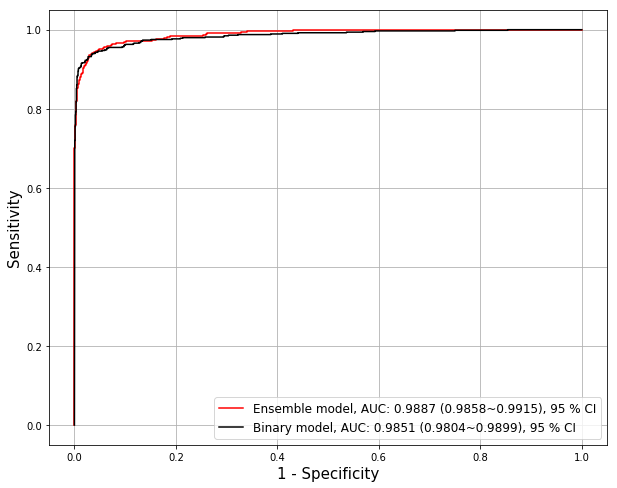

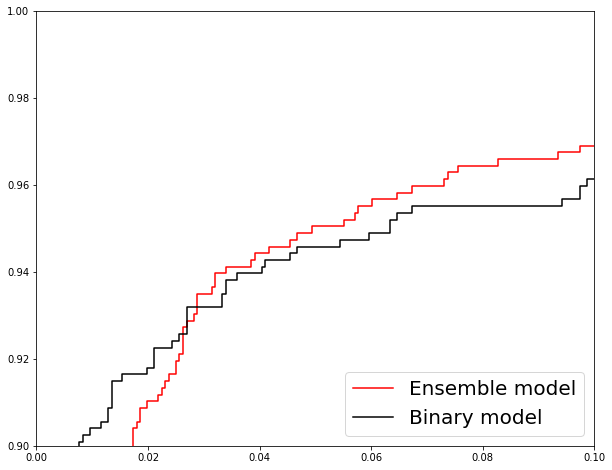

In [46]:
from sklearn.metrics import roc_curve, auc

e_aucs, b_aucs = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):

    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    
    e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
    b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])
    e_aucs.append(auc(e_fpr, e_tpr))
    b_aucs.append(auc(b_fpr, b_tpr))

e_auc_m, e_auc_l, e_auc_u = conf_interval(e_aucs, mode = 'value')
b_auc_m, b_auc_l, b_auc_u = conf_interval(b_aucs, mode = 'value')

labels = np.vstack([neg_label, h_label, d_label])
b_outputs = np.vstack([neg_b_output, h_b_output, d_b_output])
e_outputs = np.vstack([neg_e_output, h_e_output, d_e_output])

labels, b_outputs, e_outputs = tri_shuffle(labels, b_outputs, e_outputs)

e_fpr, e_tpr, thresholds = roc_curve(labels[:, 1], e_outputs[:,1])
b_fpr, b_tpr, thresholds = roc_curve(labels[:, 1], b_outputs[:,1])

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(e_auc_m, e_auc_l, e_auc_u))
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model, AUC: {:.4f} ({:.4f}~{:.4f}), 95 % CI".format(b_auc_m, b_auc_l, b_auc_u))
plt.xlabel('1 - Specificity', fontsize = 15)
plt.ylabel('Sensitivity', fontsize = 15)
plt.legend(fontsize = 12)
plt.grid('on')
fig.show()

fig = plt.figure(figsize=(10, 8))
plt.plot(e_fpr, e_tpr, 'r-', label="Ensemble model")
plt.plot(b_fpr, b_tpr, 'k-', label="Binary model")
plt.xlim([0.0, 0.1])
plt.ylim([0.9, 1.0])
plt.legend(fontsize = 20, loc = 4)
fig.show()

## Statistics

![image](http://mblogthumb3.phinf.naver.net/20121114_106/istech7_1352875002440GYyqh_PNG/%B5%CE%C1%FD%B4%DC%C2%F7%C0%CC_%B0%CB%C1%A4%B9%E6%B9%FD%C8%E5%B8%A7%B5%B5.png?type=w2)

![image](https://t1.daumcdn.net/cfile/tistory/2743524658F2520C2A)

https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F1378B94E4F9C187F23

In [47]:
e_CM, b_CM = [], []

for n_idx, h_idx, d_idx in zip(neg_idxs, h_idxs, d_idxs):
    labels = np.vstack([neg_label[n_idx], h_label[h_idx], d_label[d_idx]])
    b_outputs = np.vstack([neg_b_output[n_idx], h_b_output[h_idx], d_b_output[d_idx]]) 
    e_outputs = np.vstack([neg_e_output[n_idx], h_e_output[h_idx], d_e_output[d_idx]]) 
    e_CM.append(cls.con_mat(labels, e_outputs)), b_CM.append(cls.con_mat(labels, b_outputs))

In [48]:
b_metrices = []
e_metrices = []

for e_cm, b_cm in zip(e_CM, b_CM):
    b_metrices.append(cls.cm2metric(b_cm))
    e_metrices.append(cls.cm2metric(e_cm))
    
b_metrices = np.asarray(b_metrices)
e_metrices = np.asarray(e_metrices)

In [49]:
b_metrices

array([[0.96412556, 0.93939394, 0.97452229, 0.97452229, 0.93939394],
       [0.95045045, 0.90909091, 0.96794872, 0.96178344, 0.92307692],
       [0.96832579, 0.95384615, 0.97435897, 0.98064516, 0.93939394],
       [0.95475113, 0.92307692, 0.96794872, 0.96794872, 0.92307692],
       [0.95909091, 0.921875  , 0.97435897, 0.96815287, 0.93650794],
       [0.95909091, 0.921875  , 0.97435897, 0.96815287, 0.93650794],
       [0.96818182, 0.90625   , 0.99358974, 0.96273292, 0.98305085],
       [0.96818182, 0.921875  , 0.98717949, 0.96855346, 0.96721311],
       [0.96818182, 0.9375    , 0.98076923, 0.97452229, 0.95238095],
       [0.96363636, 0.890625  , 0.99358974, 0.95679012, 0.98275862]])

In [50]:
e_metrices

array([[0.90134529, 0.95454545, 0.87898089, 0.9787234 , 0.76829268],
       [0.92342342, 0.96969697, 0.90384615, 0.98601399, 0.81012658],
       [0.92307692, 0.98461538, 0.8974359 , 0.9929078 , 0.8       ],
       [0.90497738, 0.98461538, 0.87179487, 0.99270073, 0.76190476],
       [0.90909091, 0.984375  , 0.87820513, 0.99275362, 0.76829268],
       [0.93636364, 0.96875   , 0.92307692, 0.98630137, 0.83783784],
       [0.91818182, 0.953125  , 0.90384615, 0.97916667, 0.80263158],
       [0.91363636, 0.953125  , 0.8974359 , 0.97902098, 0.79220779],
       [0.93181818, 1.        , 0.90384615, 1.        , 0.81012658],
       [0.91363636, 0.953125  , 0.8974359 , 0.97902098, 0.79220779]])

In [51]:
print("95 % CI\n")

print('Binary model')
conf_interval(100*b_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*b_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*b_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*b_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*b_metrices[:, 4], mode = 'print', metric = 'PPV')
print('')
print('Ensemble model')
conf_interval(100*e_metrices[:, 0], mode = 'print', metric = 'Accr')
conf_interval(100*e_metrices[:, 1], mode = 'print', metric = 'Sen')
conf_interval(100*e_metrices[:, 2], mode = 'print', metric = 'Spec')
conf_interval(100*e_metrices[:, 3], mode = 'print', metric = 'NPV')
conf_interval(100*e_metrices[:, 4], mode = 'print', metric = 'PPV')

95 % CI

Binary model
Accr --- 96.24 (95.79 ~ 96.69)
Sen --- 92.25 (90.96 ~ 93.55)
Spec --- 97.89 (97.20 ~ 98.57)
NPV --- 96.84 (96.34 ~ 97.34)
PPV --- 94.83 (93.24 ~ 96.43)

Ensemble model
Accr --- 91.76 (90.95 ~ 92.56)
Sen --- 97.06 (95.84 ~ 98.28)
Spec --- 89.56 (88.46 ~ 90.66)
NPV --- 98.67 (98.12 ~ 99.21)
PPV --- 79.44 (77.77 ~ 81.11)


### Equal-Variance Test

In [52]:
from scipy.stats import bartlett

accr_stats = bartlett(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = bartlett(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = bartlett(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = bartlett(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = bartlett(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("bartlett test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("bartlett test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("bartlett test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("bartlett test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("bartlett test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

bartlett test for accuracy: 2.673, pvalue=0.102093266221
bartlett test for sensitivity: 0.030, pvalue=0.863065534512
bartlett test for specificity: 1.825, pvalue=0.176745755054
bartlett test for negative predictive values: 0.077, pvalue=0.781952568466
bartlett test for positive predictive values: 0.018, pvalue=0.893344349084


In [53]:
from scipy.stats import levene

accr_stats = levene(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = levene(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = levene(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = levene(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = levene(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("levene test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("levene test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("levene test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("levene test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("levene test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

levene test for accuracy: 2.939, pvalue=0.103646541633
levene test for sensitivity: 0.095, pvalue=0.761624160134
levene test for specificity: 0.846, pvalue=0.369946357502
levene test for negative predictive values: 0.510, pvalue=0.484310633810
levene test for positive predictive values: 0.028, pvalue=0.868672840014


### Normality Test

In [54]:
from scipy.stats import ks_2samp

accr_stats = ks_2samp(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ks_2samp(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ks_2samp(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ks_2samp(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ks_2samp(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("Kolmogorov-Smirnov test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("Kolmogorov-Smirnov test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("Kolmogorov-Smirnov test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("Kolmogorov-Smirnov test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("Kolmogorov-Smirnov test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

Kolmogorov-Smirnov test for accuracy: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for sensitivity: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for specificity: 1.000, pvalue=0.000010825088
Kolmogorov-Smirnov test for negative predictive values: 0.900, pvalue=0.000216501764
Kolmogorov-Smirnov test for positive predictive values: 1.000, pvalue=0.000010825088


### Wilcoxon signed-ranks test (not normal and paired group)

In [55]:
from scipy.stats import wilcoxon

accr_stats = wilcoxon(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = wilcoxon(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = wilcoxon(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = wilcoxon(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = wilcoxon(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("wilcoxon signed-ranks test for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("wilcoxon signed-ranks test for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("wilcoxon signed-ranks test for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("wilcoxon signed-ranks test for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("wilcoxon signed-ranks test for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

wilcoxon signed-ranks test for accuracy: 0.000, pvalue=0.005033508201
wilcoxon signed-ranks test for sensitivity: 0.000, pvalue=0.004920313984
wilcoxon signed-ranks test for specificity: 0.000, pvalue=0.004892240902
wilcoxon signed-ranks test for negative predictive values: 0.000, pvalue=0.005062032126
wilcoxon signed-ranks test for positive predictive values: 0.000, pvalue=0.005062032126


### Paired two-sample t-Test (normal and paired group)

In [56]:
from scipy.stats import ttest_rel

accr_stats = ttest_rel(100*b_metrices[:, 0], 100*e_metrices[:, 0])
sens_stats = ttest_rel(100*b_metrices[:, 1], 100*e_metrices[:, 1])
spec_stats = ttest_rel(100*b_metrices[:, 2], 100*e_metrices[:, 2])
npv_stats = ttest_rel(100*b_metrices[:, 3], 100*e_metrices[:, 3])
ppv_stats = ttest_rel(100*b_metrices[:, 4], 100*e_metrices[:, 4])

print("t-statistics for accuracy: {:.3f}, pvalue={:.12f}".format(accr_stats[0], accr_stats[1]))
print("t-statistics for sensitivity: {:.3f}, pvalue={:.12f}".format(sens_stats[0], sens_stats[1]))
print("t-statistics for specificity: {:.3f}, pvalue={:.12f}".format(spec_stats[0], spec_stats[1]))
print("t-statistics for negative predictive values: {:.3f}, pvalue={:.12f}".format(npv_stats[0], npv_stats[1]))
print("t-statistics for positive predictive values: {:.3f}, pvalue={:.12f}".format(ppv_stats[0], ppv_stats[1]))

t-statistics for accuracy: 11.377, pvalue=0.000001211374
t-statistics for sensitivity: -8.887, pvalue=0.000009470091
t-statistics for specificity: 16.829, pvalue=0.000000041377
t-statistics for negative predictive values: -7.887, pvalue=0.000024804438
t-statistics for positive predictive values: 16.211, pvalue=0.000000057368


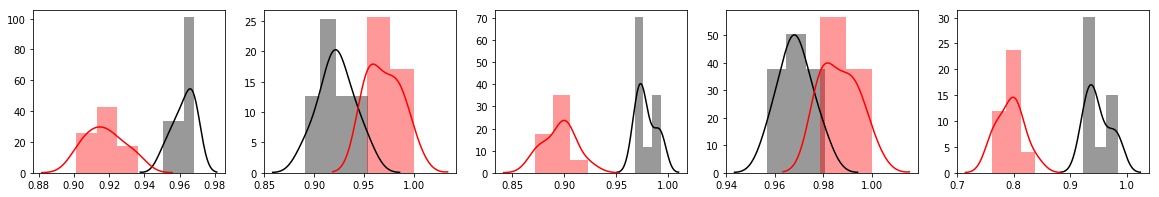

In [57]:
## Distribution by metric

import seaborn as sns

fig, axes = plt.subplots(ncols = 5)
fig.set_size_inches(20, 3)

sns.set_style({'axes.grid' : True})

sns.distplot(b_metrices[:, 0], color='k', ax = axes[0])
sns.distplot(e_metrices[:, 0], color='r', ax = axes[0])
sns.distplot(b_metrices[:, 1], color='k', ax = axes[1])
sns.distplot(e_metrices[:, 1], color='r', ax = axes[1])
sns.distplot(b_metrices[:, 2], color='k', ax = axes[2])
sns.distplot(e_metrices[:, 2], color='r', ax = axes[2])
sns.distplot(b_metrices[:, 3], color='k', ax = axes[3])
sns.distplot(e_metrices[:, 3], color='r', ax = axes[3])
sns.distplot(b_metrices[:, 4], color='k', ax = axes[4])
sns.distplot(e_metrices[:, 4], color='r', ax = axes[4])

fig.show()